In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

# 1. Introduction
THORLABS have demonstrated how to modulate the spatial output profile of a multimode fiber by changing the incidence angle of the light at the input of the same fiber. The method is detailed in their technical document: [Modifying Beam Profiles with Multimode Fibers](https://www.thorlabs.com/images/TabImages/Multimode_Fiber_Beam_Lab_Fact.pdf).  

On slide number 7, they describe the spatial light profile at the fiber output as following a different *super Gaussian* for an input angle of zero and eleven degrees. The *super Gaussian* equation is given as:  
  
$$\large y = A {\rm e}^{-2\left(\frac{x-x_0}{\omega}\right)^{\beta}},$$  
where $A$ is a normalization factor, $x_0$ is a decenter, $\omega$ is related to the width of the function, and $\beta$ is related to how *square* the function is. To illustrate this last point, I'm plotting different *super Gaussian* with $A = 1$, $x_0 = 0$, $\omega = 1$, and $\beta = \{2, 4, 8, 16, 1000\}$.

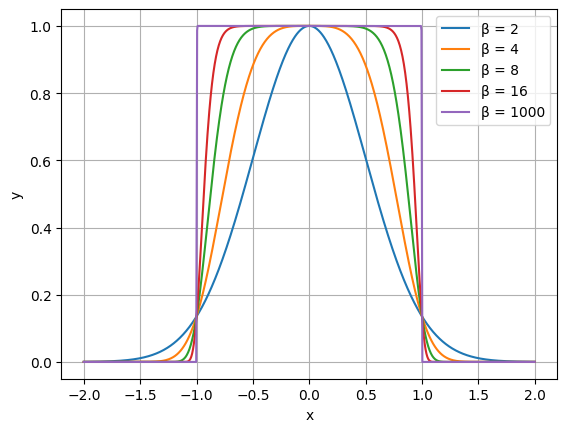

In [2]:
xx = np.linspace(-2, 2, 1000)

I_2 = np.exp( -2 * ( xx ) ** 2 )
I_4 = np.exp( -2 * ( xx ) ** 4 )
I_8 = np.exp( -2 * ( xx ) ** 8 )
I_16 = np.exp( -2 * ( xx ) ** 16 )
I_1000 = np.exp( -2 * ( xx ) ** 1000 )

plt.figure()
plt.plot(xx, I_2, label='\u03B2 = 2')
plt.plot(xx, I_4, label='\u03B2 = 4')
plt.plot(xx, I_8, label='\u03B2 = 8')
plt.plot(xx, I_16, label='\u03B2 = 16')
plt.plot(xx, I_1000, label='\u03B2 = 1000')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

THORLABS gives the following values for the two cases: zero, and eleven degrees:  
#### Zero degree
- $A = 1$
- $x_0 = 519$
- $\omega = 375$
- $\beta = 4$  
#### Eleven degree
- $A = 1$
- $x_0 = 519$
- $\omega = 375$
- $\beta = 16$  
  
$x_0$ and $\omega$ are given in pixels.  

How can we use this information to create a source in OpticStudio that would model the spatial light distribution at the output of a multimode fiber as described by THORLABS? In the following section, I'll try to explain how I went about answering this question.  
# 2. The naive (and also wrong) approach
OpticStudio sources need ray starting coordinates (X-Y) whose distribution model the spatial light distribution at the source origin. To generate those starting coordinates, I thought about doing the following, starting in polar coordinates, I would:
- sample a random radius from the *super Gaussian*
- sample an angle uniformly in the interval $[0, 2\pi)$
- transform the radius and angle into Cartesian coordinates  

**However, there are a number of issues with that approach.**  

First, it is not obvious how one should go about generating random radii from any given distribution. For that, I found the work of Harry45: [Sampling from any distribution](https://harry45.github.io/blog/2016/10/Sampling-From-Any-Distribution) quite helpful. I will not elaborate here because I did not end up using it, but Harry45 shows how one can subclass ```scipy.stats.rv_continuous``` with any distribution, and use the ```rvs``` method to generate the random samples from that distribution. Note that this only works for univariate (1D) distributions.  

Second, that approach doesn't work, for the same reason as discussed in the Stackoverflow question: [Generate a random point within a circle uniformly](https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly). In short, the random coordinates agglomerate around the origin, and the spatial distribution isn't a *super Gaussian* anymore. The same Stackoverflow question gives a general method to generate the radii correctly, but it involves calculating the Cumulative Distribution Function (CDF), which is an integral of the *super Gaussian* and taking its inverse. However, integrating the *super Gaussian* function proved difficult, and I went about this problem in a different way. But at first, it was difficult to find a solution to this problem, and one reason is that the *super Gaussian* function is not the only name that is given to that function. Let's take a step back and understand what the *super Gaussian* function is.

# 3. What is a *super Gaussian*?
After searching for some time, I figured that what THORLABS calls a *super Gaussian*, mathematicians call it a [generalized normal (or Gaussian) distribution](https://en.wikipedia.org/wiki/Generalized_normal_distribution). And, in our 2D case, the more common denomination seems to be **bivariate generalized Gaussian distribution (BGGD)**. Someone in Stackexchange posted a [MATLAB code to produce a BGGD](https://stats.stackexchange.com/questions/189548/multivariate-asymmetric-generalized-gaussian-distribution). The post is based on Eq. 2 of a paper called *On the Geometry of Multivariate Generalized Gaussian Models* (DOI 10.1007/s10851-011-0297-8). If we rewrite Eq. 2 with $m = 2$, and $\boldsymbol{\mu} = 0$ (because we can easily decenter a source in OpticStudio), we get:  

$$f(\boldsymbol{x}) = \frac{1}{\pi\Gamma\left(\frac{1}{\alpha}\right)2^\alpha}\frac{\alpha}{|\Sigma|^\frac{1}{2}}\exp{\left(-\frac{1}{2}\left[\boldsymbol{x}^T\Sigma^{-1}\boldsymbol{x}\right]^\alpha\right)},$$  

where $\boldsymbol{x}$ is a two-dimensional vector, think of $(x, y)$ coordinates, $\Sigma$ is referred to as a two-by-two dispersion matrix, and $\alpha$ is actually half of our *super Gaussian* $\beta$ (because they document the special case $\alpha = 1$ as being the bivariate Gaussian distribution). **Note that in the paper, Eq. 2 uses $\beta$ but I've used $\alpha$ for clarity**. I think $\Sigma$ plays the same role as our *super Gaussian* parameter $\omega$ in two dimensions. For a symmetric BGGD, I've chosen $\Sigma$ as:  

$$\Sigma = \left[\begin{smallmatrix} \omega & 0 \\ 0 & \omega \end{smallmatrix}\right]$$  
If we develop the tensor product, the term in the exponential becomes:  

$$\left[\boldsymbol{x}^T\Sigma^{-1}\boldsymbol{x}\right]^\alpha = \frac{x^2 + y^2}{\omega}.$$  
With this last bit of information, I decided to transform my *super Gaussian* into a BGGD. Empirically, I found that I could use a bivariate distribution as such:

$$f_{BGGD}(x, y) = {\rm e}^{-2\left(\frac{x^2 + y^2}{\omega^2}\right)^{\alpha}},$$  
and it would reproduce the univariate *super Gaussian*. **Note the $^2$ exponent on $\omega$**. Since it is more of an empirical result, let me show you the verification I did.

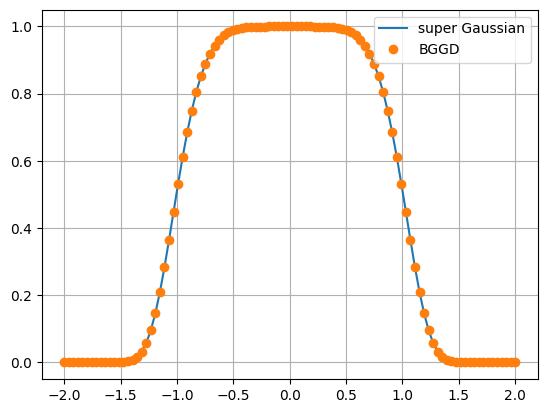

In [3]:
import matplotlib.pyplot as plt
import numpy as np


# univariate super Gaussian (SG)
def SG(xx, omega, beta):
    return np.exp( -2 * ( xx / omega )**beta )

# Bivariate generalized Gaussian distribution (BGGD)
def BGGD(xx, yy, omega, alpha):
    return np.exp( -2 * ( ( xx**2 + yy**2 ) / omega**2 )**alpha )

# Linear grid
grid = np.linspace(-2, 2, 100)

# Meshgrid
xx, yy = np.meshgrid(grid, grid)

# Test parameters
beta = 6 # <=================== Experiment with this parameter using even integers greater of equal to two
omega = 1.2 # <================= Experiment with this parameter using positive floating-point numbers (adjust the grid as necessary)

# Result of the SG over the grid
f_sg = SG(grid, omega, beta)

# Result of the BGGD over the grid
f_bggd = BGGD(xx, yy, omega, int(beta / 2))

# Plot the SG and compare it with the central row of BGGD
plt.figure()
plt.plot(grid, f_sg, label='super Gaussian')
plt.plot(grid, f_bggd[int(f_bggd.shape[0]/2),:], label='BGGD', marker='o', linewidth=0)
plt.grid()
plt.legend()
plt.show()

# 4. How to sample the Bivariate Generalized Gaussian Distribution (BGGD)
Assuming my empirical BGGD is correct, how shall we generate random points from it in a circle? I decided to try the **rejection sampling** approach, mainly because I stumbled across this Math Stackexchange question: [Generating random numbers from a non uniform distribution over a unit circle](https://math.stackexchange.com/questions/2655278/generating-random-numbers-from-a-non-uniform-distribution-over-a-unit-circle). While I don't understand the maths behind, it seems like I can choose a random $(x, y)$ pair of coordinates uniformly in a square space around the origin, and another number $u$ choosen uniformly in the interval $[0, 1)$. If $u > f_{BGGD}(x, y)$, then I reject this coordinate, otherwise I accept it. Let's see how this work in code.

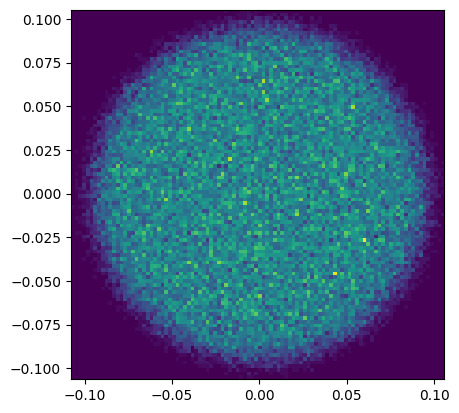

In [4]:
import matplotlib.pyplot as plt
import numpy as np


# univariate super Gaussian (SG)
def SG(xx, omega, beta):
    return np.exp( -2 * ( xx / omega )**beta )

# Bivariate generalized Gaussian distribution (BGGD)
def BGGD(xx, yy, omega, alpha):
    return np.exp( -2 * ( ( xx**2 + yy**2 ) / omega**2 )**alpha )

# BGGD parameters
omega = 0.1
beta = 16
alpha = int( beta / 2 )

# Number of points required
required = 100000

# Number of points accepted
accepted = 0

# List of coordinates
points_x = []
points_y = []

# Loop until the required number of point is reached
while accepted < required:
    # Generate a random point inside a square grid that is five times the size of omega in both directions
    xx = 2 * 2 * omega * (np.random.rand() - 0.5)
    yy = 2 * 2 * omega * (np.random.rand() - 0.5)
    
    # Calculate the probability of that random point
    zz = BGGD(xx, yy, omega, alpha)

    # Generate a random value in the interval [0, 1)
    uu = np.random.rand()
    
    # Accept the point if uu <= zz
    if uu <= zz:
        points_x.append(xx)
        points_y.append(yy)
        
        accepted += 1
    
# Make a 2D histogram of the points
n_bins = 100
heatmap, xedges, yedges = np.histogram2d(points_x, points_y, bins=n_bins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.figure()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

I'll try to implement this in a Source DLL, and I'll update this notebook accordingly once its done.